In [12]:
from Bio import SeqIO
import pandas as pd
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import pysam
import copy
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize


In [121]:
len('GTAGCGAAGCGGTGTGGAATGGAGCGGAATGGAGTGGAATTGAGTGGGATGGATTAGAATGGAATGGAGTGACCTAGAGTGGAGTGGAGAGGAATGGAGT')

100

In [13]:
sizes_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38_chromsome_sizes.txt', header=None)
sizes = [int(s.replace(',','')) for s in sizes_df[2]]
chrom_linear_starts = [np.sum(sizes[:i]) for i in range(23)] + [3041559849]

def loci_linear_idx(chrom, loci):
    chrom=int(chrom)
    if chrom==24: chrom=23
    return chrom_linear_starts[chrom-1]+loci

In [14]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[gaps_df['type']=='N']

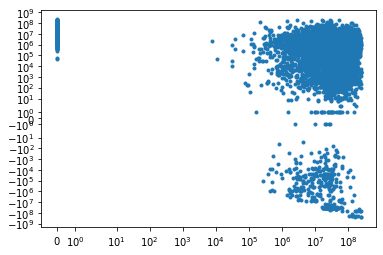

In [96]:
A = comparison#[comparison['chrom_aligned']==comparison['chrom_localized']]
dist = [np.max([0,i,j]) for i,j in zip(A.start_localized-A.start_aligned, A.start_aligned-A.end_localized)]
loc_region = A.end_localized-A.start_localized
plt.plot(dist, loc_region, '.')
plt.xscale('symlog')
plt.yscale('symlog')

In [102]:
np.mean(loc_region>0)

0.9601212686567164

In [122]:
localized_ends = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unmapped/localized_T2T_end.bed', 
                               index_col=3, header=None, nrows=1000)
localized_starts = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/localize/unmapped/localized_T2T_start.bed', 
                                 index_col=3, header=None, nrows=1000)

N = max(localized_ends.index+1)

In [ ]:
localized_starts

In [77]:
print(np.mean(comparison[comparison.is_same_loc].has_multiple_alignments))
print(np.mean(comparison[~comparison.is_same_loc].has_multiple_alignments))
print(np.mean(comparison[comparison.is_same_loc].AS))
print(np.mean(comparison[~comparison.is_same_loc].AS))


0.17545638945233266
0.27233201581027666
93.86916835699797
89.46903820816864


In [81]:
print(Counter(comparison[~comparison.is_same_loc].chrom_aligned).most_common(10))
print(Counter(comparison[comparison.is_same_loc].chrom_aligned).most_common(10))


[('9', 3322), ('22', 987), ('14', 772), ('21', 594), ('15', 434), ('13', 388), ('20', 173), ('1', 154), ('7', 129), ('5', 118)]
[('9', 788), ('20', 34), ('5', 33), ('1', 22), ('10', 22), ('17', 17), ('7', 16), ('22', 10), ('3', 8), ('4', 7)]


In [67]:
Counter(comparison[comparison.is_same_loc].AS).most_common(10)

[(95, 385),
 (100, 244),
 (90, 126),
 (85, 27),
 (96, 23),
 (93, 16),
 (99, 14),
 (92, 14),
 (80, 12),
 (94, 12)]

In [58]:
metrics_sort = metrics.loc[set(localized_starts.index).intersection(metrics.index)]
metrics_sort = metrics_sort.loc[sorted(metrics_sort.index)]
metrics_sort

,chrom_aligned,start_aligned,has_multiple_alignments,AS,is_new_loc
0,,,,,
0,chr4,169960664.0,True,87,False
21,chr9,54133729.0,False,95,False
35,chr9,76442480.0,False,90,False
41,chr9,76673052.0,False,30,False
52,chr22,6054248.0,False,100,False
...,...,...,...,...,...
61409,chr7,58556604.0,False,95,False
61410,chr9,75762484.0,True,100,False
61411,chr20,32141904.0,False,93,False


# Set up files.

In [57]:
N = max(max(localized_ends.index), max(localized_starts.index))+1
unmapped_t2t = pd.read_table("/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_unmapped.bed", header=None, comment='#', 
                            nrows=N)
unmapped_t2t.index = unmapped_t2t[3]


# Load unmapped read alignments to CHM13.
samfile = pysam.AlignmentFile("/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned.sam", "r")
metrics = [None for i in range(N)]
for x in samfile.fetch():
    if int(x.query_name)>=N: break
    else: metrics[int(x.query_name)] = (int(x.query_name),x.reference_name, 
                                   0 if (x.reference_start is None) or (x.reference_end is None) else (x.reference_start+x.reference_end)/2,
                                   True if 'XA' in [i[0] for i in x.get_tags()] else False,
                                   x.get_tag('AS'))
    
metrics = pd.DataFrame(metrics)#[(int(x.query_name),x.reference_name, 0 if (x.reference_start is None) or (x.reference_end is None) else (x.reference_start+x.reference_end)/2,
                 # True if 'XA' in [i[0] for i in x.get_tags()] else False,
                 #  x.get_tag('AS'))
                 # for x in samfile.fetch()])
metrics.index = metrics[0]
metrics.drop(0, axis=1,inplace=True)
metrics = metrics[~pd.isnull(metrics[1])]

## New column for whether or not an alignment is on a newly assembled in CHM13 that doesn't exist in HG38. (Liftover FAILED reads.)
metrics['is_new_loc'] = False
metrics.loc[set(unmapped_t2t.index).intersection(metrics.index)]['is_new_loc'] = True
metrics.columns = ['chrom_aligned', 'start_aligned', 'has_multiple_alignments', 'AS', 'is_new_loc']

In [18]:
# What regions are missing from T2T

In [19]:
missing_from_t2t_start = list(set(localized_starts.index).difference(metrics.index))
missing_from_t2t_end = list(set(localized_ends.index).difference(metrics.index))
missing_from_t2t = list(set(missing_from_t2t_start).intersection(missing_from_t2t_end))
print(len(missing_from_t2t)/len(localized_starts), 'missing from T2T')

0.1011 missing from T2T


In [20]:
localized_missing_from_t2t = localized_starts.loc[missing_from_t2t]
localized_missing_from_t2t.columns = ['chrom', 'start', 'end']

In [21]:
localized_missing_from_t2t_linear_id =[loci_linear_idx(chrom.replace('X','24').replace('M','24').replace('chr', ''),start) for chrom,start in zip(
    localized_missing_from_t2t['chrom'],
    (localized_missing_from_t2t['start']+localized_missing_from_t2t['end'])/2)]



In [22]:
Counter(localized_missing_from_t2t['chrom']).most_common(10)

[('chr6', 204),
 ('chr12', 179),
 ('chr14', 122),
 ('chr2', 59),
 ('chr1', 41),
 ('chr8', 40),
 ('chr19', 37),
 ('chr3', 36),
 ('chr4', 34),
 ('chr9', 34)]

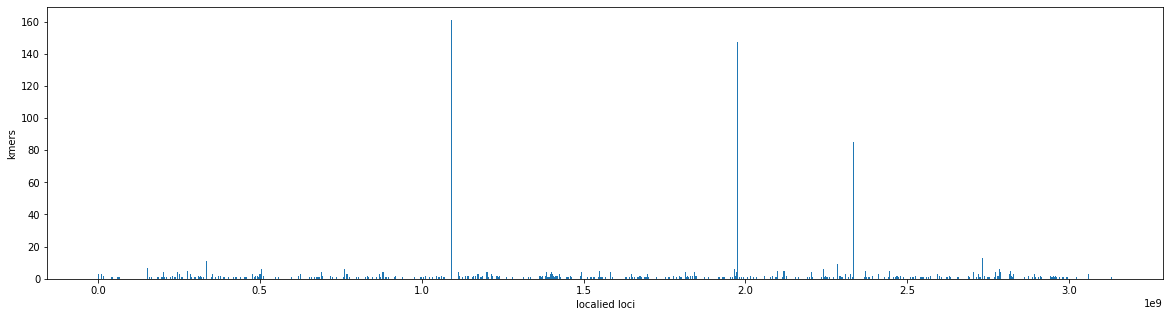

In [23]:
plt.subplots(figsize=(20,5))
plt.hist(localized_missing_from_t2t_linear_id, bins=1000)
plt.xlabel('localied loci')
plt.ylabel('kmers')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/missing_from_t2t_genetic_variation.svg', transparent=True)
plt.show()

In [106]:
idxs = set(localized_ends.index).intersection(localized_starts.index).intersection(metrics.index)
comparison = copy.deepcopy(metrics.loc[idxs])
comparison

,chrom_aligned,start_aligned,has_multiple_alignments,AS,is_new_loc
0,,,,,
0,chr4,169960664.0,True,87,False
32768,chr22,6953197.0,False,100,False
32778,chr9,54916708.0,False,95,False
21,chr9,54133729.0,False,95,False
32790,chr9,67412274.5,False,71,False
...,...,...,...,...,...
32745,chr21,5852008.0,True,95,False
32747,chr22,2468058.0,False,87,False
32753,chr22,2415548.0,True,93,False


In [ ]:
idxs = sorted(set(localized_ends.index).intersection(localized_starts.index).intersection(metrics.index))
comparison = copy.deepcopy(metrics.loc[idxs])
comparison = comparison.sample(len(comparison),replace=True)
comparison['chrom_localized'] = localized_starts.loc[idxs][0]
comparison['start_localized'] = localized_starts.loc[idxs][1]
comparison['end_localized'] = localized_ends.loc[idxs][1]
comparison

In [119]:
correctly_localized = comparison[(comparison['start_aligned']>=comparison['start_localized']) &
              (comparison['start_aligned']<=comparison['end_localized']) & (
                  comparison['chrom_localized']==comparison['chrom_aligned'])]
incorrectly_localized = comparison[~((comparison['start_aligned']>=comparison['start_localized']) &
              (comparison['start_aligned']<=comparison['end_localized']) & (
                  comparison['chrom_localized']==comparison['chrom_aligned']))]

incorrectly_chrom_localized = comparison[comparison['chrom_localized']!=comparison['chrom_aligned']]

In [120]:
print((len(comparison)-len(incorrectly_chrom_localized))/len(comparison), 'localized to right chrom')
print(len(correctly_localized)/(len(correctly_localized)+len(incorrectly_localized)), 'localized fully correctly')

0.28603078358208955 localized to right chrom
0.12126865671641791 localized fully correctly


In [27]:
print(Counter(correctly_localized['chrom_aligned']).most_common(10))
print(Counter(incorrectly_localized['chrom_aligned']).most_common(10))

[('chr9', 788), ('chr20', 34), ('chr5', 33), ('chr1', 22), ('chr10', 22), ('chr17', 17), ('chr7', 16), ('chr22', 10), ('chr3', 8), ('chr4', 7)]
[('chr9', 3322), ('chr22', 987), ('chr14', 772), ('chr21', 594), ('chr15', 434), ('chr13', 388), ('chr20', 173), ('chr1', 154), ('chr7', 129), ('chr5', 118)]


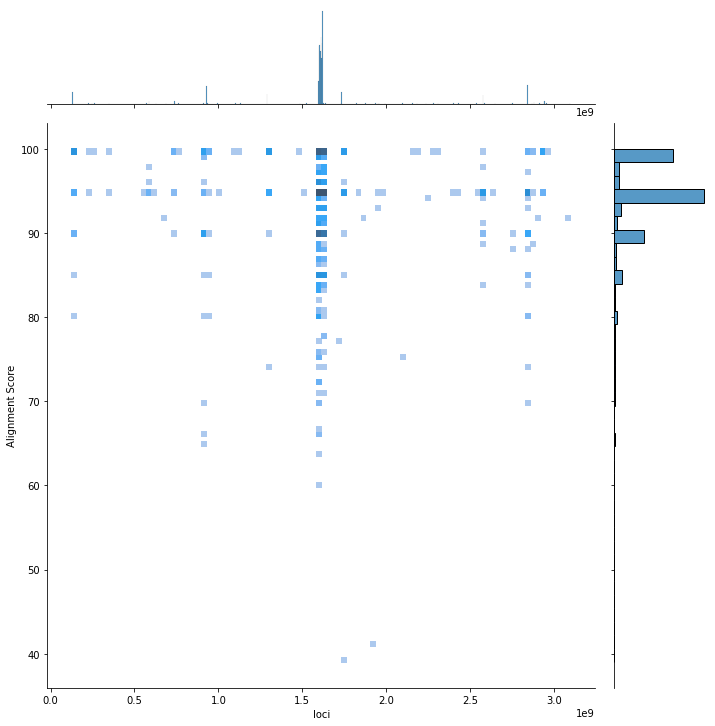

In [28]:
correctly_localized_linear_id = [loci_linear_idx(chrom.replace('X','24').replace('M','24').replace('chr', ''),start) for chrom,start in zip(
    correctly_localized['chrom_aligned'],
    correctly_localized['start_aligned'])]
jp = sns.jointplot(x=correctly_localized_linear_id,y=correctly_localized['AS'], kind='hist', norm=LogNorm(), 
                   bins=100, height=10, vmin=None, vmax=None)
plt.xlabel('loci')
plt.ylabel('Alignment Score')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/loci_vs_alignment_score_correct.svg', transparent=True)
plt.show()



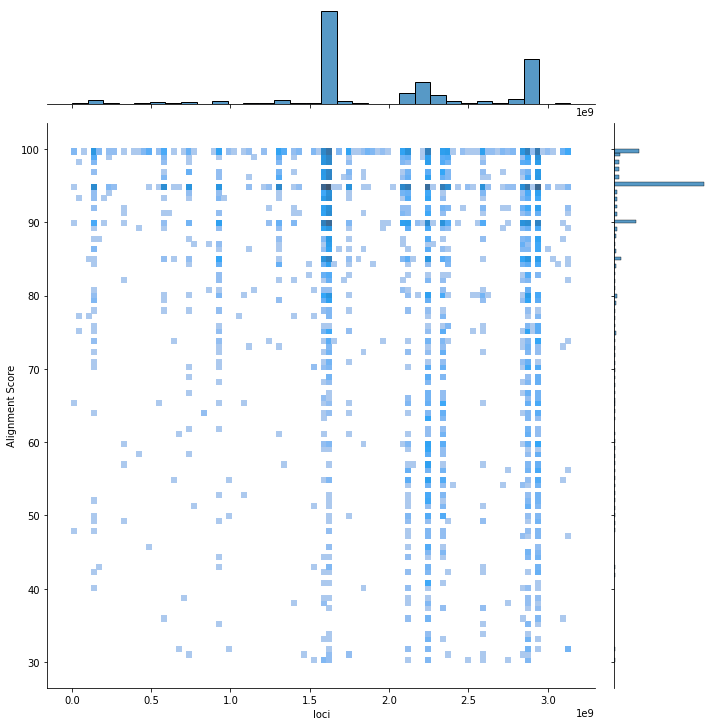

In [29]:
incorrectly_localized = comparison[~((comparison['start_aligned']>=comparison['start_localized']) &
              (comparison['start_aligned']<=comparison['end_localized']) & (
                  comparison['chrom_localized']==comparison['chrom_aligned']))]
incorrectly_localized_linear_id = [loci_linear_idx(chrom.replace('X','24').replace('M','24').replace('chr', ''),start) for chrom,start in zip(
    incorrectly_localized['chrom_aligned'],
    incorrectly_localized['start_aligned'])]
jp = sns.jointplot(x=incorrectly_localized_linear_id,y=incorrectly_localized['AS'], kind='hist', norm=LogNorm(), 
                   bins=100, height=10, vmin=None, vmax=None)
plt.xlabel('loci')
plt.ylabel('Alignment Score')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/loci_vs_alignment_score_incorrect.svg', transparent=True)
plt.show()



In [123]:
# Getting location of gaps in the hg38, using T2T coordinate system. 
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_t2t_aligned = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/gaps_hg38_t2t_aligned_starts.bed', header=None)
gaps_t2t_aligned.index = gaps_t2t_aligned[3]
gaps_df = gaps_df.loc[gaps_t2t_aligned.index]
gaps_t2t_aligned = gaps_t2t_aligned[gaps_df['type']=='N']
gaps_t2t_aligned.columns = ['chrom', 'start', 'stop', 'idx']
gaps_t2t_aligned['chrom'] = [c.replace('chr', '') for c in gaps_t2t_aligned['chrom'] ]

Text(0, 0.5, 'Alignment Algorithm')

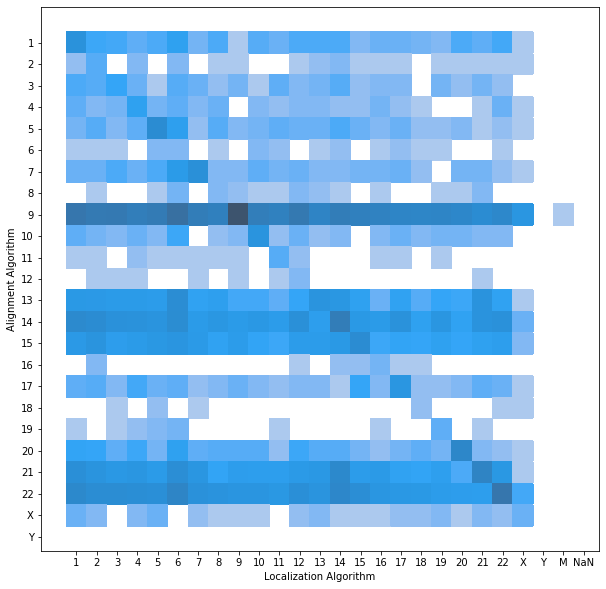

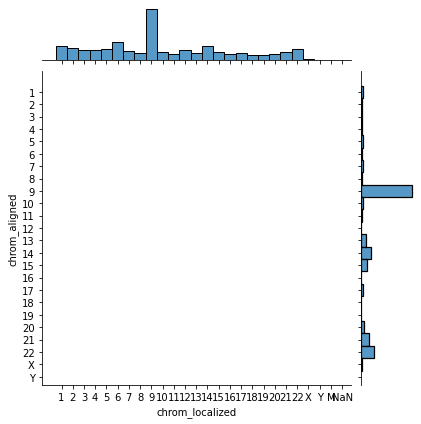

In [30]:
comparison['chrom_aligned'] = pd.Categorical([str(i).replace('chr', '') for i in comparison['chrom_aligned']], categories=[str(i) for i in range(1,23)] + ['X', 'Y', 'M','NaN'], ordered=True)
comparison['chrom_localized'] = pd.Categorical([str(i).replace('chr', '') for i in comparison['chrom_localized']],
                                               categories=[str(i) for i in range(1,23)] + ['X', 'Y', 'M','NaN'], ordered=True)
comparison['is_same_chrom'] = comparison['chrom_localized']==comparison['chrom_aligned']
comparison['is_same_loc'] = False
comparison.loc[correctly_localized.index,'is_same_loc'] = True

f,ax = plt.subplots(figsize=(10,10))
sns.jointplot(x=comparison['chrom_localized'], y=comparison['chrom_aligned'], ax=ax, kind='hist', norm=LogNorm(), vmin=None, vmax=None)
ax.set_xlabel('Localization Algorithm')
ax.set_ylabel('Alignment Algorithm')

0.47790055248618785 localized the same


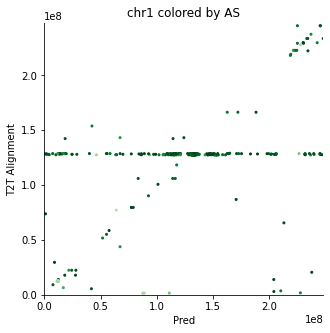

0.5833333333333334 localized the same


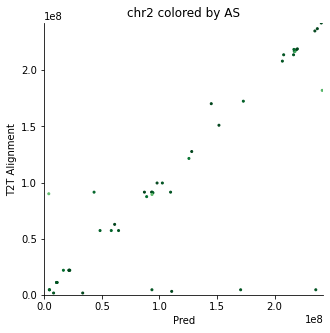

0.44036697247706424 localized the same


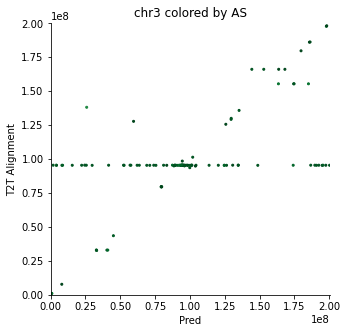

0.47619047619047616 localized the same


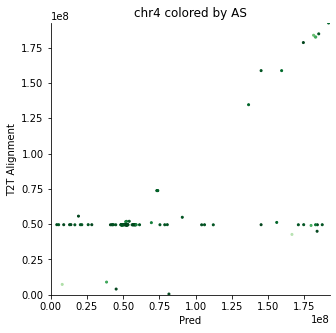

0.6414686825053996 localized the same


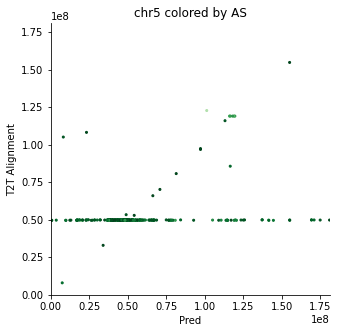

0.45348837209302323 localized the same


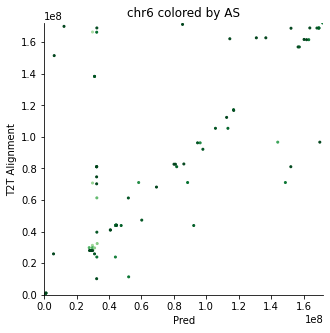

0.510556621880998 localized the same


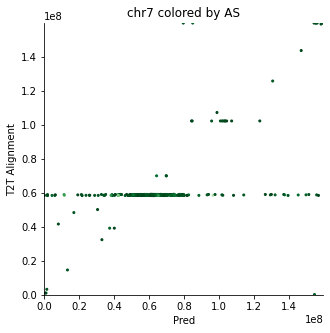

0.6944444444444444 localized the same


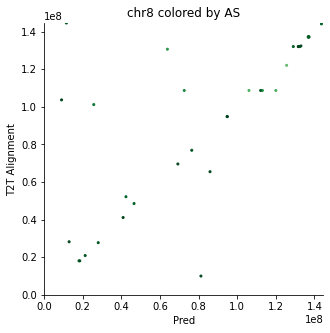

0.4725531131032789 localized the same


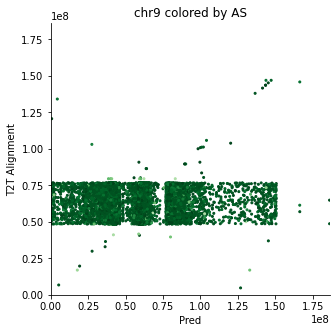

0.6379310344827587 localized the same


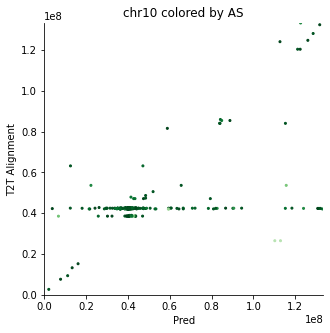

0.5932203389830508 localized the same


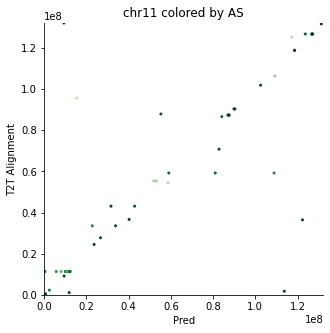

0.5666666666666667 localized the same


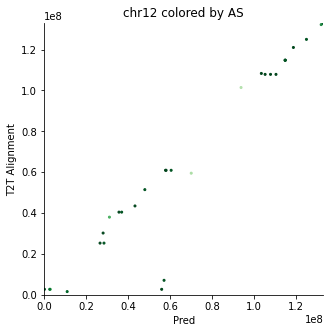

0.09907120743034056 localized the same


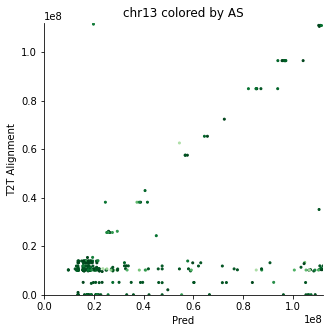

0.019966722129783693 localized the same


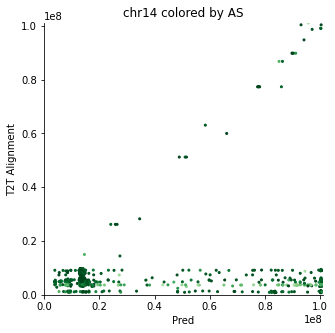

0.021956087824351298 localized the same


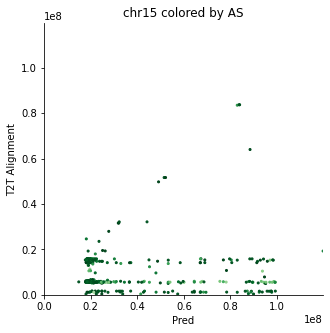

0.4 localized the same


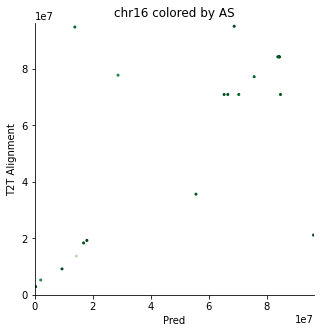

0.5666666666666667 localized the same


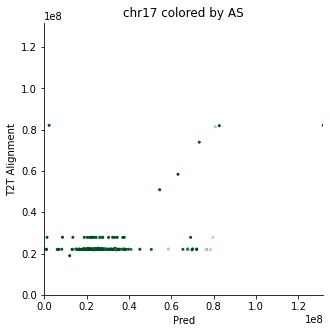

0.8333333333333334 localized the same


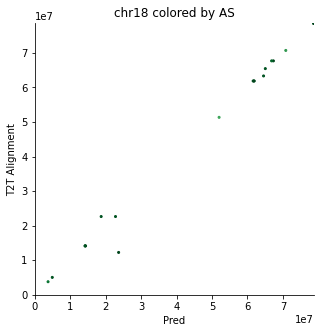

0.4375 localized the same


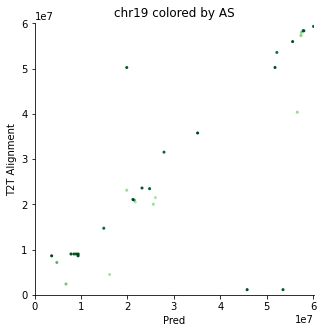

0.5672823218997362 localized the same


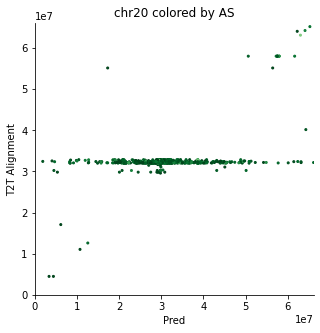

0.07464607464607464 localized the same


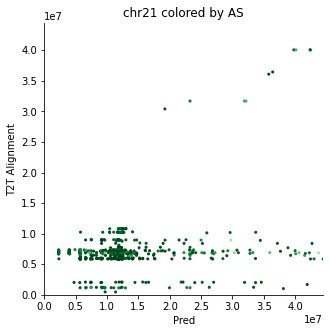

0.05564142194744977 localized the same


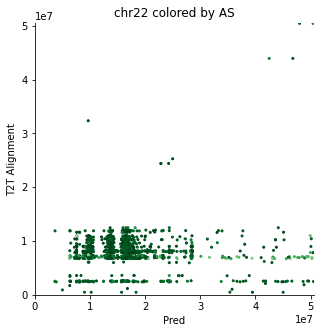

0.4 localized the same


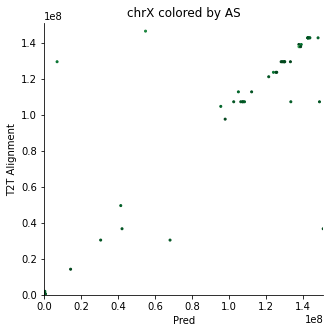

In [126]:
# Coloring by alignment score
for chrom in [str(ch) for ch in range(1,23)]+['X']:
    current_slice = comparison[(comparison['chrom_aligned']==chrom) & (comparison['chrom_localized']==chrom)]
    loci_aligned = current_slice.start_aligned
    loci_localized = (current_slice.start_localized+current_slice.end_localized)/2
    gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
    gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]
    max_val = max([max(loci_aligned), max(loci_localized)])
    f, ax = plt.subplots(figsize=(5,5))
    if False:
        for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
            r = Rectangle(xy=(start+0*loci_linear_idx(chrom.replace('chr', ''), start), 0),
                          height=max_val, width=stop-start, color='grey', alpha=.5)
            r1 = Rectangle(xy=(0,start+0*loci_linear_idx(chrom.replace('chr', ''), start)),
                        width=max_val, height=stop-start, color='grey', alpha=.5)
            ax.add_patch(r)
            ax.add_patch(r1)
        

    red_patch = mpatches.Patch(color='red')
    blue_patch = mpatches.Patch(color='blue')

    grey_patch = mpatches.Patch(color='grey')
    plt.scatter(loci_localized, loci_aligned, c=current_slice['AS'], s=4, alpha=1, cmap='Greens', vmin=0, vmax=100)
    plt.plot()
    plt.ylim(0,max_val)
    plt.xlim(0,max_val)
    plt.ylabel('T2T Alignment')
    plt.xlabel('Pred')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('chr' + chrom + ' colored by AS')
    #plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.svg', transparent=True)
    print(np.mean((current_slice['start_aligned']>=current_slice['start_localized']) &
                  (current_slice['start_aligned']<=current_slice['end_localized'])), 'localized the same')
    plt.show()

0.4827586206896552 localized the same


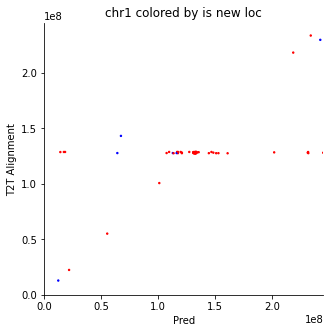

0.6 localized the same


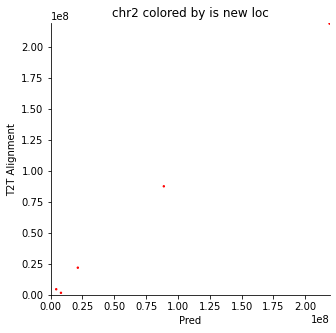

0.3333333333333333 localized the same


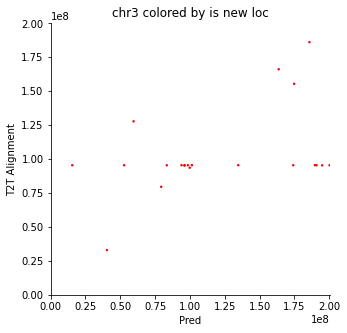

0.5263157894736842 localized the same


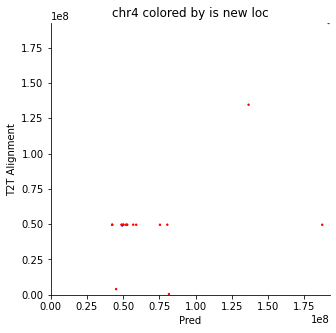

0.5949367088607594 localized the same


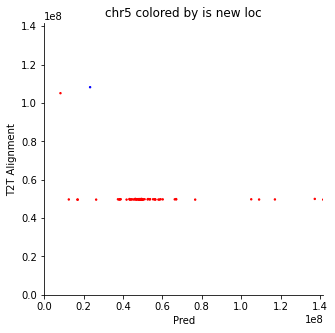

0.4375 localized the same


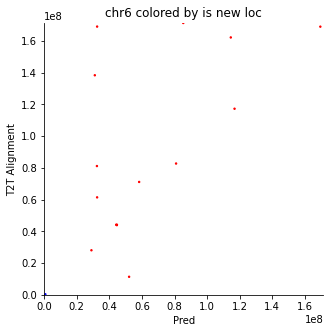

0.5051546391752577 localized the same


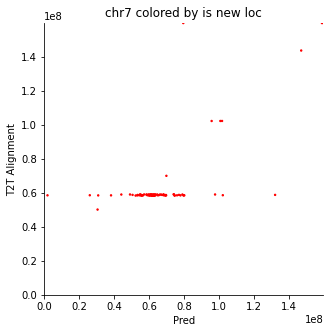

0.8333333333333334 localized the same


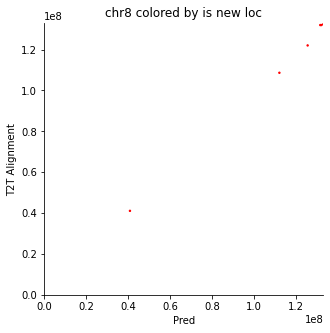

0.45860566448801743 localized the same


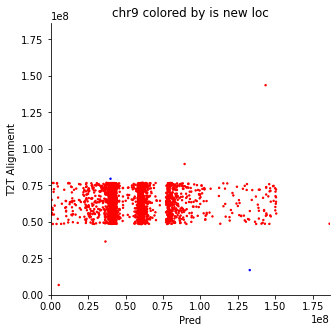

0.6382978723404256 localized the same


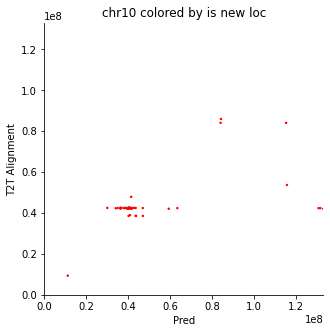

0.25 localized the same


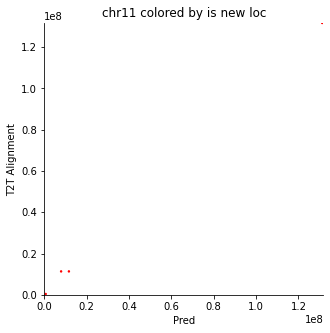

0.3333333333333333 localized the same


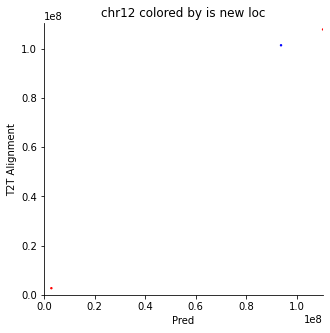

0.09836065573770492 localized the same


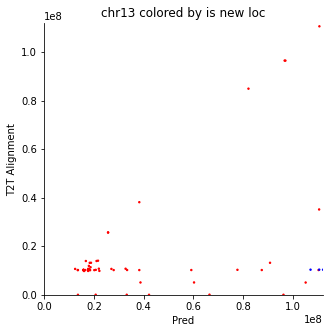

0.018691588785046728 localized the same


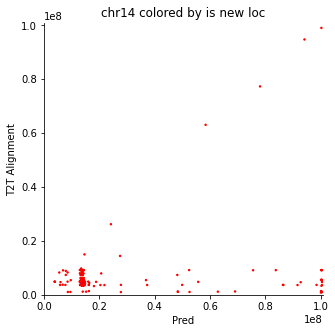

0.011627906976744186 localized the same


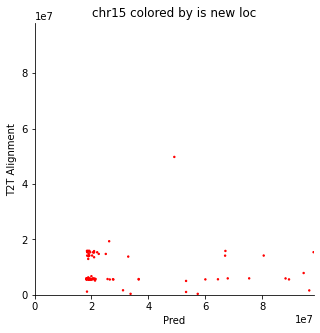

0.0 localized the same


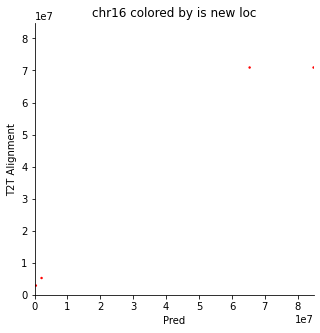

0.5510204081632653 localized the same


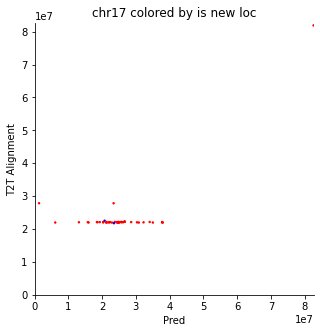

1.0 localized the same


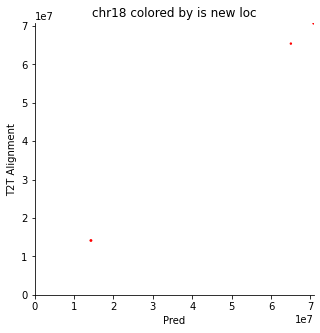

0.2 localized the same


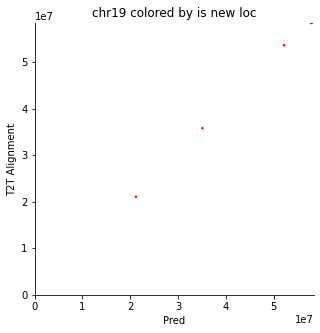

0.5378151260504201 localized the same


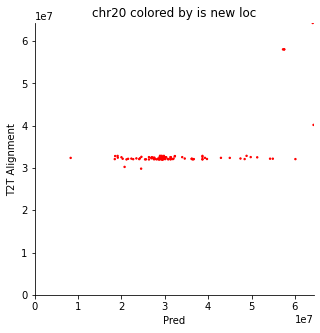

0.05426356589147287 localized the same


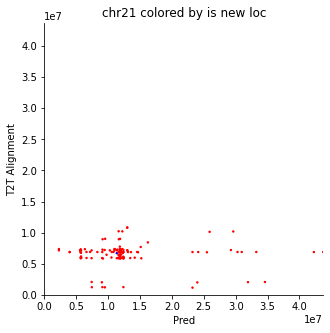

0.0547112462006079 localized the same


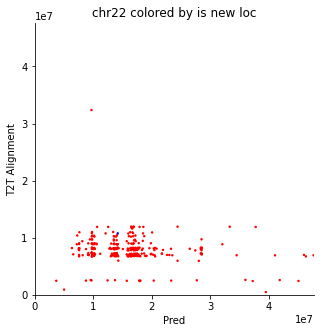

0.2222222222222222 localized the same


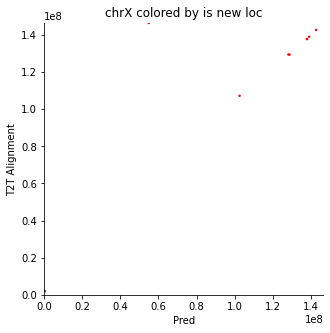

In [112]:
# Coloring by whether its a gap or not
for chrom in [str(ch) for ch in range(1,23)]+['X']:
    current_slice = comparison[(comparison['chrom_aligned']==chrom) & (comparison['chrom_localized']==chrom)]
    loci_aligned = current_slice.start_aligned
    loci_localized = (current_slice.start_localized+current_slice.end_localized)/2
    gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
    gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]
    max_val = max([max(loci_aligned), max(loci_localized)])
    f, ax = plt.subplots(figsize=(5,5))
    if False:
        for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
            r = Rectangle(xy=(start+0*loci_linear_idx(chrom.replace('chr', ''), start), 0),
                          height=max_val, width=stop-start, color='grey', alpha=.5)
            r1 = Rectangle(xy=(0,start+0*loci_linear_idx(chrom.replace('chr', ''), start)),
                        width=max_val, height=stop-start, color='grey', alpha=.5)
            ax.add_patch(r)
            ax.add_patch(r1)
        

    red_patch = mpatches.Patch(color='red')
    blue_patch = mpatches.Patch(color='blue')

    grey_patch = mpatches.Patch(color='grey')
    plt.scatter(loci_localized, loci_aligned, c=current_slice['is_new_loc'], s=2, alpha=1, cmap='bwr', vmin=0, vmax=1)
    plt.plot()
    plt.ylim(0,max_val)
    plt.xlim(0,max_val)
    plt.ylabel('T2T Alignment')
    plt.xlabel('Pred')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('chr' + chrom + ' colored by is new loc')
    #plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.svg', transparent=True)
    print(np.mean((current_slice['start_aligned']>=current_slice['start_localized']) &
                  (current_slice['start_aligned']<=current_slice['end_localized'])), 'localized the same')
    plt.show()

0.47790055248618785 localized the same


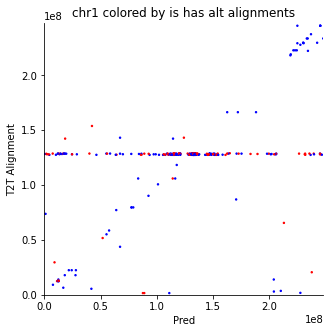

0.5833333333333334 localized the same


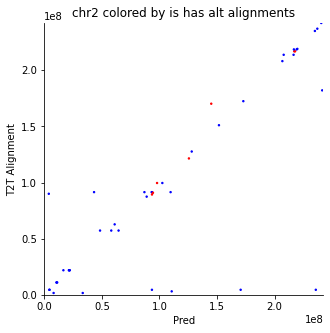

0.44036697247706424 localized the same


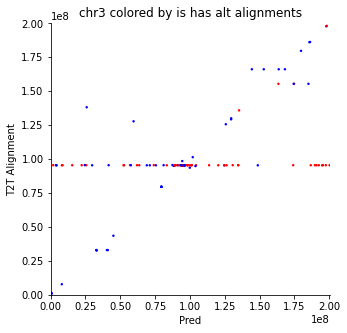

0.47619047619047616 localized the same


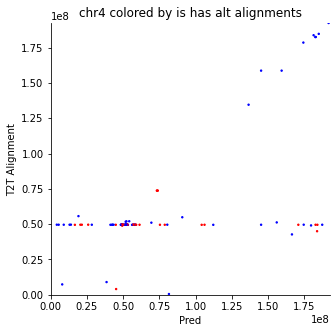

0.6414686825053996 localized the same


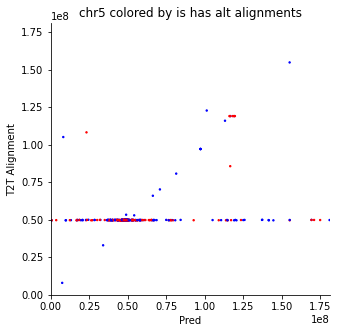

0.45348837209302323 localized the same


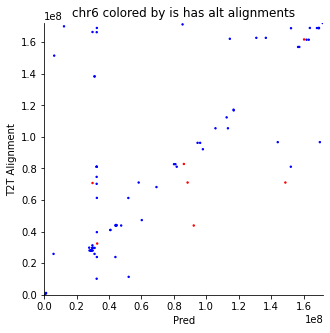

0.510556621880998 localized the same


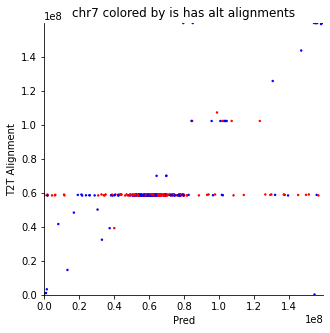

0.6944444444444444 localized the same


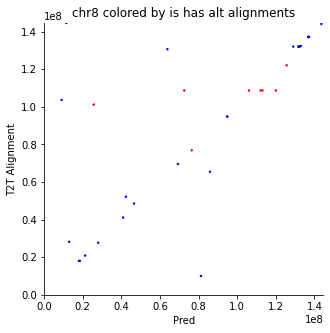

0.4725531131032789 localized the same


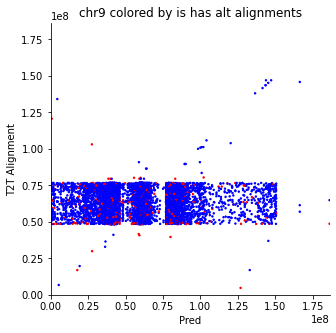

0.6379310344827587 localized the same


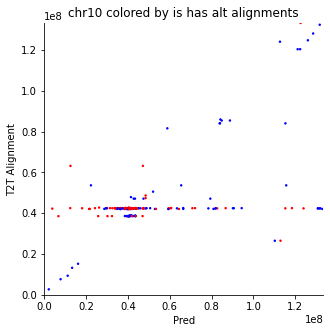

0.5932203389830508 localized the same


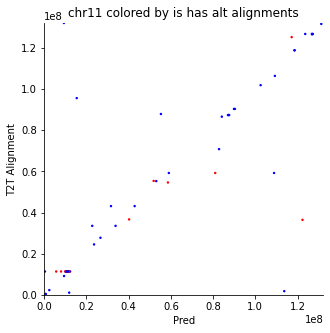

0.5666666666666667 localized the same


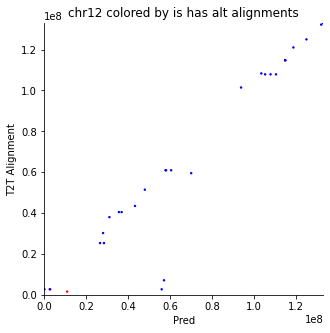

0.09907120743034056 localized the same


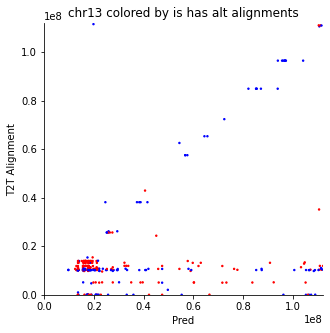

0.019966722129783693 localized the same


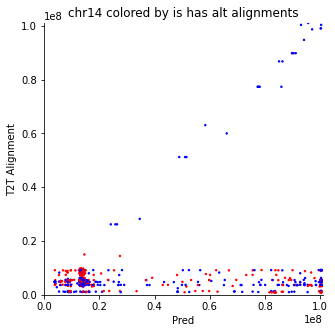

0.021956087824351298 localized the same


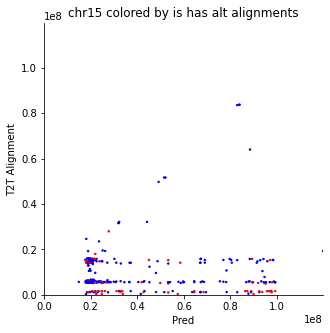

0.4 localized the same


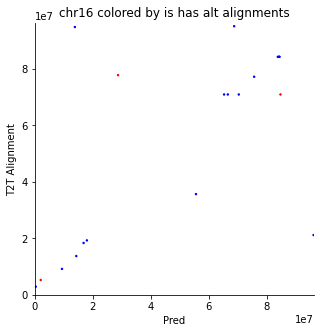

0.5666666666666667 localized the same


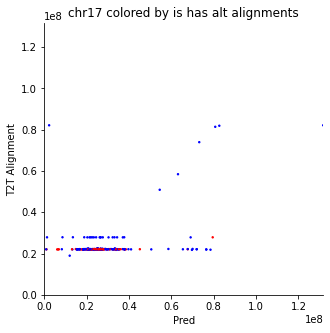

0.8333333333333334 localized the same


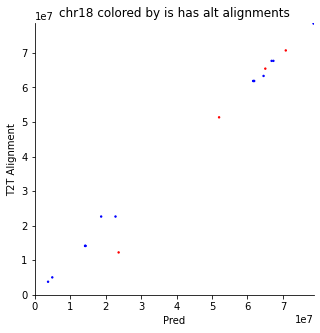

0.4375 localized the same


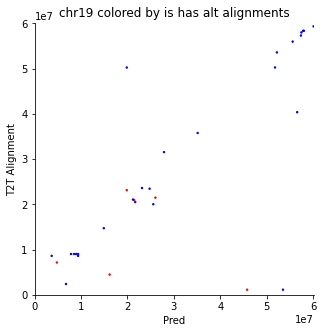

0.5672823218997362 localized the same


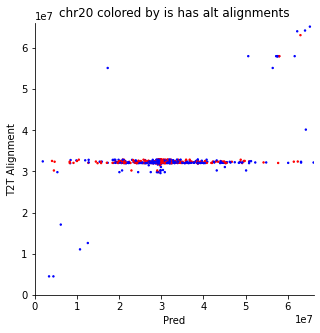

0.07464607464607464 localized the same


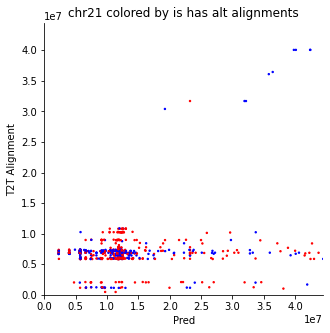

0.05564142194744977 localized the same


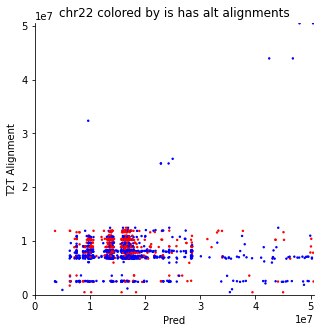

0.4 localized the same


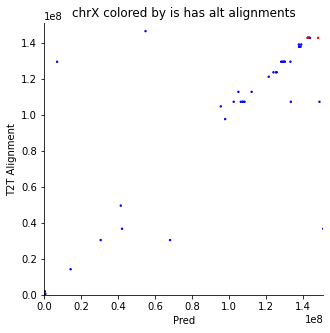

In [127]:
# Coloring by whether its a gap or not
for chrom in [str(ch) for ch in range(1,23)]+['X']:
    current_slice = comparison[(comparison['chrom_aligned']==chrom) & (comparison['chrom_localized']==chrom)]
    loci_aligned = current_slice.start_aligned
    loci_localized = (current_slice.start_localized+current_slice.end_localized)/2
    gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
    gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]
    max_val = max([max(loci_aligned), max(loci_localized)])
    f, ax = plt.subplots(figsize=(5,5))
    if False:
        for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
            r = Rectangle(xy=(start+0*loci_linear_idx(chrom.replace('chr', ''), start), 0),
                          height=max_val, width=stop-start, color='grey', alpha=.5)
            r1 = Rectangle(xy=(0,start+0*loci_linear_idx(chrom.replace('chr', ''), start)),
                        width=max_val, height=stop-start, color='grey', alpha=.5)
            ax.add_patch(r)
            ax.add_patch(r1)
        

    red_patch = mpatches.Patch(color='red')
    blue_patch = mpatches.Patch(color='blue')

    grey_patch = mpatches.Patch(color='grey')
    plt.scatter(loci_localized, loci_aligned, c=current_slice['has_multiple_alignments'], s=2, alpha=1, cmap='bwr', vmin=0, vmax=1)
    plt.ylim(0,max_val)
    plt.xlim(0,max_val)
    plt.ylabel('T2T Alignment')
    plt.xlabel('Pred')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('chr' + chrom + ' colored by is has alt alignments')
    #plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.svg', transparent=True)
    print(np.mean((current_slice['start_aligned']>=current_slice['start_localized']) &
                  (current_slice['start_aligned']<=current_slice['end_localized'])), 'localized the same')
    plt.show()

# Printing some metrics

------------

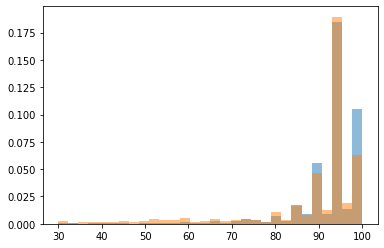

frac with alt mapping
0.20835055808185202
0.2819554978073737
frac with new loc in T2T
0.0
0.0


In [31]:
plt.hist(comparison[comparison.chrom_localized==comparison.chrom_aligned]['AS'], alpha=.5, density=True,bins=30)
plt.hist(comparison[comparison.chrom_localized!=comparison.chrom_aligned]['AS'], alpha=.5, density=True,bins=30)
plt.show()
print('frac with alt mapping')
print(np.mean(comparison[comparison.chrom_localized==comparison.chrom_aligned]['has_multiple_alignments']))
print(np.mean(comparison[comparison.chrom_localized!=comparison.chrom_aligned]['has_multiple_alignments']))

print('frac with new loc in T2T')
print(np.mean(comparison[comparison.chrom_localized==comparison.chrom_aligned]['is_new_loc']))
print(np.mean(comparison[comparison.chrom_localized!=comparison.chrom_aligned]['is_new_loc']))

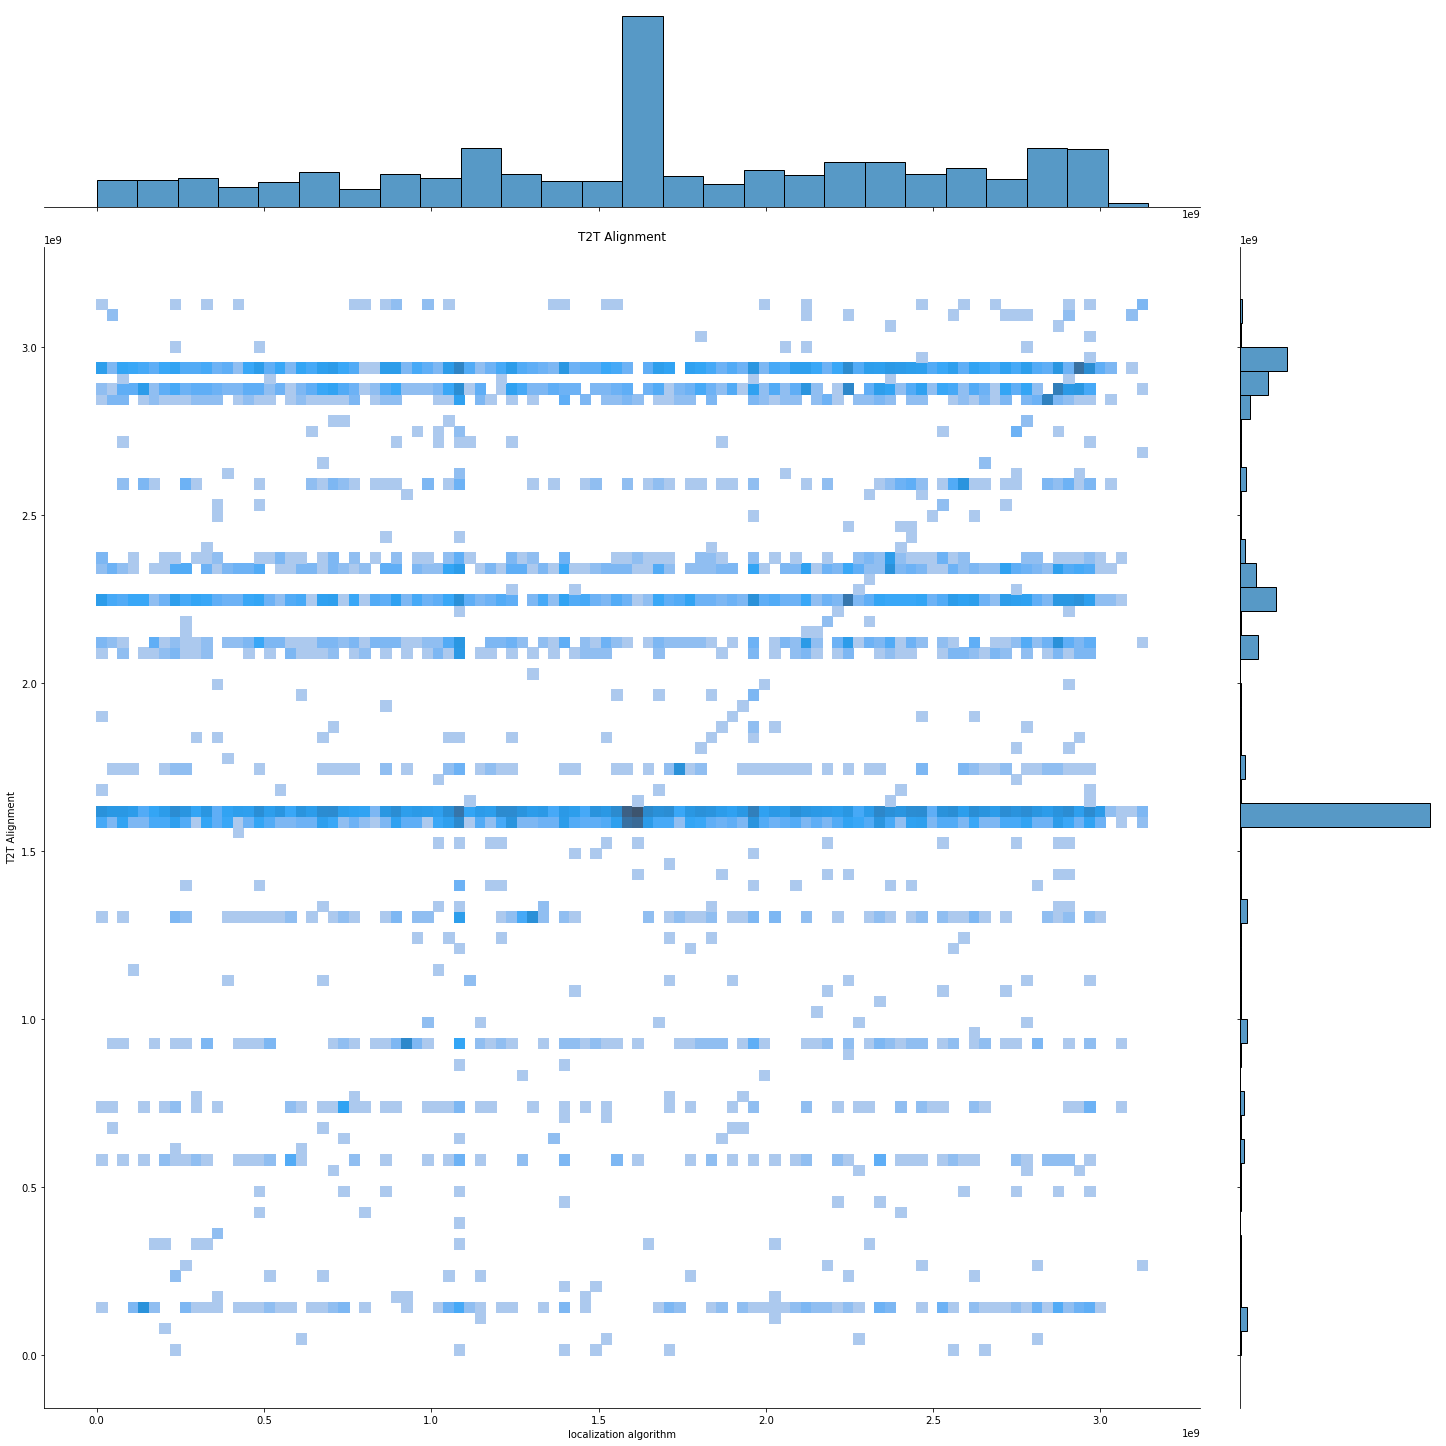

array([[1.        , 0.13238941],
       [0.13238941, 1.        ]])

In [32]:
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

#f, ax = plt.subplots(figsize=(20,20))
if False:
    for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
        r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                      height=3047968796, width=stop-start, color='grey', alpha=.5)
        r1 = Rectangle(xy=(0,loci_linear_idx(chrom.replace('chr', ''), start)),
                    width=3047968796, height=stop-start, color='grey', alpha=.5)
        ax.add_patch(r)
        ax.add_patch(r1)
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

localized =[loci_linear_idx(chrom.replace('X','24').replace('M','24'),start) for chrom,start in zip(comparison['chrom_localized'],
                                                             (comparison['start_localized']+comparison['end_localized'])/2)]
aligned =[loci_linear_idx(chrom.replace('X','24').replace('M','24'),start) for chrom,start in zip(comparison['chrom_aligned'],
                                                             comparison['start_aligned'])]
jp = sns.jointplot(x=localized,y=aligned, kind='hist', norm=LogNorm(), bins=100, height=20, vmin=None, vmax=None)
plt.xlabel('localization algorithm')
plt.ylabel('T2T Alignment')
#plt.spines['top'].set_visible(False)
#plt.spines['right'].set_visible(False)
plt.title('T2T Alignment')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/comparison_t2t_location.svg', transparent=True)
plt.show()
np.corrcoef(localized, aligned)
#plt.xlabel('localized')
#plt.aligend('localized')

In [33]:
comparison_filt = comparison[(comparison['AS']==100) & (~comparison['has_multiple_alignments'])]
print(np.mean(comparison_filt.is_same_chrom))
print(np.mean(comparison_filt.is_same_loc))

0.4857142857142857
0.24285714285714285


In [38]:
comparison_filt

,chrom_aligned,start_aligned,has_multiple_alignments,AS,is_new_loc,chrom_localized,start_localized,end_localized,is_same_chrom,is_same_loc
0,,,,,,,,,,
32768,22,6953197.0,False,100,False,22,16039342,17335684,True,False
52,22,6054248.0,False,100,False,17,18608655,18900148,False,False
32824,9,57049400.0,False,100,False,2,64839225,65022813,False,False
93,9,69865948.0,False,100,False,3,182655333,183811196,False,False
146,17,21999166.0,False,100,False,4,165841830,169213196,False,False
...,...,...,...,...,...,...,...,...,...,...
32082,9,63616617.0,False,100,False,9,77073156,78553573,True,False
32104,1,127705150.0,False,100,False,1,120982996,143027731,True,True
32123,9,63667374.0,False,100,False,1,98344606,99647756,False,False


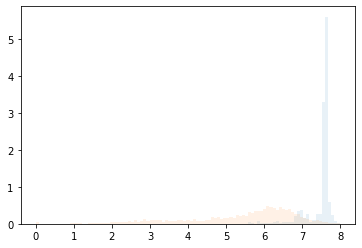

In [47]:
plt.hist(np.log10(comparison[comparison.is_same_loc]['end_localized']-comparison[comparison.is_same_loc]['start_localized']),
         alpha=.1, density=True, bins=np.linspace(0,8,100))
plt.hist(np.log10(comparison[~comparison.is_same_loc]['end_localized']-comparison[~comparison.is_same_loc]['start_localized']),
         alpha=.1, density=True, bins=np.linspace(0,8,100))
plt.show()

In [37]:
print(np.median(comparison[comparison.is_same_loc]['end_localized']-comparison[comparison.is_same_loc]['start_localized']))
print(np.median(comparison_filt[comparison_filt.is_same_loc]['end_localized']-comparison_filt[comparison_filt.is_same_loc]['start_localized']))

39796324.0
39549562.5


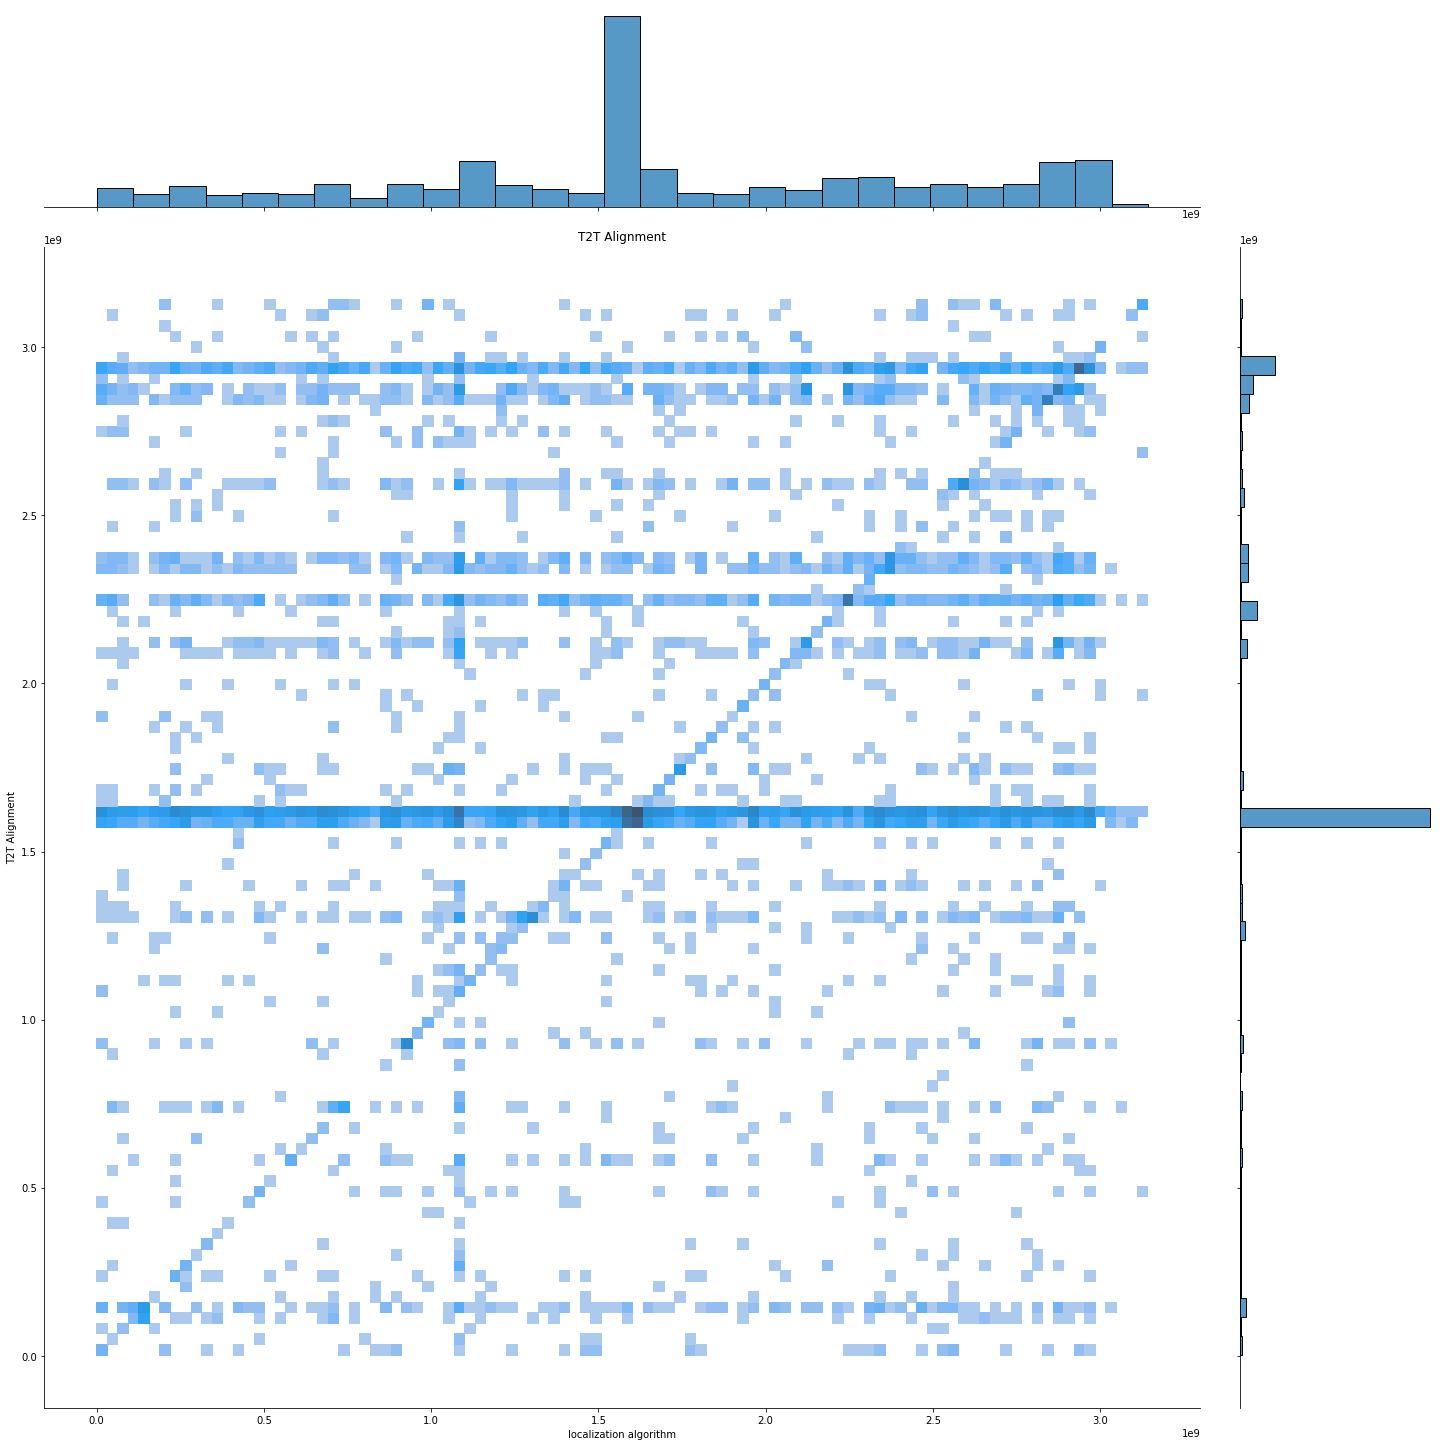

array([[1.       , 0.2531592],
       [0.2531592, 1.       ]])

In [135]:
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

#f, ax = plt.subplots(figsize=(20,20))
if False:
    for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
        r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                      height=3047968796, width=stop-start, color='grey', alpha=.5)
        r1 = Rectangle(xy=(0,loci_linear_idx(chrom.replace('chr', ''), start)),
                    width=3047968796, height=stop-start, color='grey', alpha=.5)
        ax.add_patch(r)
        ax.add_patch(r1)
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

localized =[loci_linear_idx(chrom.replace('X','24').replace('M','24'),start) for chrom,start in zip(comparison_filt['chrom_localized'],
                                                             (comparison_filt['start_localized']+comparison_filt['end_localized'])/2)]
aligned =[loci_linear_idx(chrom.replace('X','24').replace('M','24'),start) for chrom,start in zip(comparison_filt['chrom_aligned'],
                                                             comparison_filt['start_aligned'])]
jp = sns.jointplot(x=localized,y=aligned, kind='hist', norm=LogNorm(), bins=100, height=20, vmin=None, vmax=None)
plt.xlabel('localization algorithm')
plt.ylabel('T2T Alignment')
#plt.spines['top'].set_visible(False)
#plt.spines['right'].set_visible(False)
plt.title('T2T Alignment')
plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/figures/unmapped/comparison_t2t_location_filt.svg', transparent=True)
plt.show()
np.corrcoef(localized, aligned)
#plt.xlabel('localized')
#plt.aligend('localized')

/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


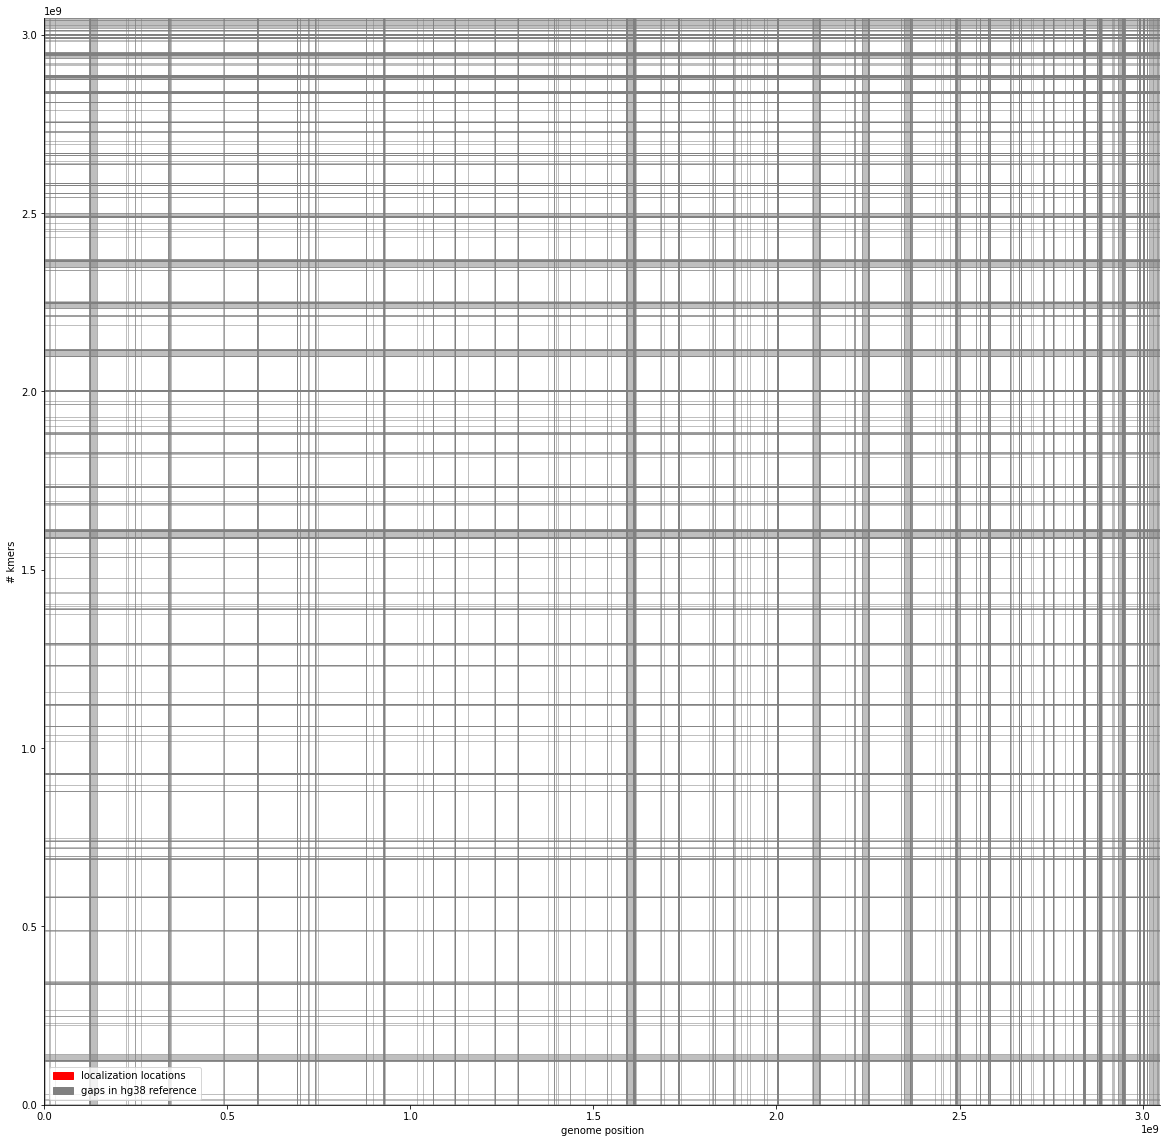

In [46]:
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

f, ax = plt.subplots(figsize=(20,20))

for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
    r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                  height=3047968796, width=stop-start, color='grey', alpha=.5)
    r1 = Rectangle(xy=(0,loci_linear_idx(chrom.replace('chr', ''), start)),
                width=3047968796, height=stop-start, color='grey', alpha=.5)
    ax.add_patch(r)
    ax.add_patch(r1)
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

#p = plt.hist(linear_locs, bins=10000, color='r')
plt.legend([red_patch, grey_patch], ['localization locations', 'gaps in hg38 reference'])
plt.xlim(0,loci_linear_idx(chrom.replace('chr', ''), stop))
plt.ylim(0,loci_linear_idx(chrom.replace('chr', ''), stop))
#plt.yscale('symlog', linthresh=1000)
plt.ylabel('# kmers')
plt.xlabel('genome position')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.svg', transparent=True)
plt.show()



In [72]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
print(sum(gaps_df['type']=='N'))
gaps_t2t_aligned = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/gaps_hg38_t2t_aligned_starts.bed', header=None)
gaps_t2t_aligned.index = gaps_t2t_aligned[3]
gaps_df = gaps_df.loc[gaps_t2t_aligned.index]
gaps_df

819


,chrom,start,stop,idx,type,ncbi_idx,location,7,8
3,,,,,,,,,
3,chr1,177418,207666,4,F,FO538757.3,2001,32249,+
4,chr1,207667,257666,5,N,50000,contig,no,na
6,chr1,297969,347968,7,N,50000,contig,no,na
8,chr1,501618,535988,9,P,FO681485.2,1,34371,-
9,chr1,535989,585988,10,N,50000,contig,no,na
...,...,...,...,...,...,...,...,...,...
395,chr1,23528238,23528514,396,O,KF495899.1,1,277,+
396,chr1,23528515,23540092,397,F,AL021154.1,78280,89857,+
397,chr1,23540093,23540321,398,O,KF510726.1,1,229,-


In [70]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df[gaps_df[4]=='N'].head(10)

,0,1,2,3,4,5,6,7,8
0,chr1,1,10000,1,N,10000,telomere,no,na
4,chr1,207667,257666,5,N,50000,contig,no,na
6,chr1,297969,347968,7,N,50000,contig,no,na
9,chr1,535989,585988,10,N,50000,contig,no,na
47,chr1,2702782,2746290,48,N,43509,scaffold,yes,unspecified
223,chr1,12954385,13004384,224,N,50000,scaffold,yes,clone_contig
276,chr1,16799164,16849163,277,N,50000,scaffold,yes,unspecified
490,chr1,29552234,29553835,491,N,1602,scaffold,yes,paired-ends
1844,chr1,121976460,122026459,1845,N,50000,contig,no,na
1846,chr1,122224536,122224635,1847,N,100,contig,no,na


In [150]:
#t2t_alignment_in_hg38_coords_unmapped = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_unmapped.bed', nrows=1000)
#t2t_alignment_in_hg38_coords = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_hg38.bed', nrows=10000, header=None)
#t2t_alignment_in_hg38_coords.index = t2t_alignment_in_hg38_coords[3]
t2t_alignment_in_t2t_coords = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_1v1.bed',
                                            nrows=1000000, header=None)
#t2t_alignment_in_t2t_coords = t2t_alignment_in_t2t_coords[t2t_alignment_in_t2t_coords[0]=='chr1']


In [ ]:
len(gaps_t2t_aligned)

In [60]:
sum(gaps_df['type']=='N')

819

In [16]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
#gaps_df = gaps_df[gaps_df.type=='N']

In [ ]:
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[gaps_df.type=='N']

f, ax = plt.subplots(figsize=(20,3))
localized = localized[~np.isnan(localized.chrom_pred)]
linear_locs = [loci_linear_idx(chrom_pred, start_pred) for chrom_pred, start_pred in zip(localized.chrom_pred, localized.start_pred)]
nbins = plt.hist(linear_locs, bins=1000, color='r')
gaps_df = pd.read_table('/home/groups/dpwall/briannac/general_data/reference_genomes/hg38/hg38_agp_file.tsv', header=None)
gaps_df.columns = ['chrom', 'start', 'stop', 'idx', 'type', 'ncbi_idx', 'location', 7, 8]
gaps_df = gaps_df[[len(c)<10 for c in gaps_df.chrom]]
gaps_df = gaps_df[gaps_df.type=='N']
gaps_df.chrom = [c.replace('X', '23').replace('Y', '24') for c in gaps_df.chrom]

f, ax = plt.subplots(figsize=(20,3))

for start, stop, chrom in zip(gaps_df.start, gaps_df.stop, gaps_df.chrom):
    r = Rectangle(xy=(loci_linear_idx(chrom.replace('chr', ''), start), 0),
                  height=1.1*max(nbins[0]), width=stop-start, color='grey', alpha=.1)
    ax.add_patch(r)
    
red_patch = mpatches.Patch(color='red')
grey_patch = mpatches.Patch(color='grey')

p = plt.hist(linear_locs, bins=10000, color='r')
plt.legend([red_patch, grey_patch], ['localization locations', 'gaps in hg38 reference'])
#plt.xlim(0,stop)
plt.yscale('symlog', linthresh=1000)
plt.ylabel('# kmers')
plt.xlabel('genome position')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.svg', transparent=True)
plt.show()



In [7]:
import pysam
bed = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_1v1.bed', nrows=10000, header=None)

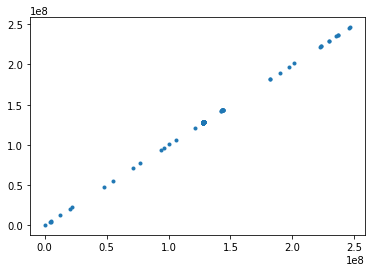

In [12]:
i = 1
loci = bed[bed[0]=='chr%i' % i][1]
plt.plot(loci, loci, '.')

In [67]:
samfile = pysam.AlignmentFile("/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/kmers_unmapped_filt_t2t_aligned_small.sam", "r")
metrics = [(x.reference_name, x.reference_start,
                  True if 'XA' in [i[0] for i in x.get_tags()] else False,
                   x.get_tag('AS'))
                  for x in samfile.fetch()]

NameError: name 'pysam' is not defined

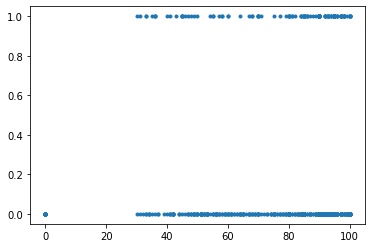

In [116]:
metrics_df = pd.DataFrame(metrics)
metrics_df[pd.isnull(metrics_df)] = np.nan
plt.plot(metrics_df[3], metrics_df[2], '.')

(array([ 99.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,   1.,
          4.,   3.,   2.,   4.,   2.,   0.,   1.,   2.,   4.,   6.,   1.,
          2.,   5.,   2.,   4.,   4.,   6.,   6.,   9.,   4.,   8.,   2.,
          5.,   7.,   4.,   4.,   4.,   6.,   4.,   2.,   2.,   6.,   5.,
          1.,   5.,   5.,   3.,   9.,   2.,   1.,   2.,   3.,   8.,   2.,
          4.,   3.,   5.,  27.,   4.,   4.,   5.,  13.,  33.,   5.,   7.,
          3.,  10., 113.,  13.,  17.,  16.,  14., 338.,  12.,  16.,  10.,
         28.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  4

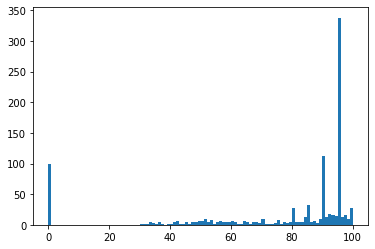

In [129]:
plt.hist(metrics_df[3], bins=100)

In [47]:
print(x.query_sequence)
print(x.get_reference_sequence())
print(np.array([i for i in x.query_sequence])==np.array([i for i in x.get_reference_sequence()]))

ATTCGATGCCATTCGATTCCTTTCTATTCGATTCCATTCAATTCCATTCGATTACCTTTTGTCCATTCTATTCCATTCGATTAAATTCAATTCCATTCTA
ATTCGATGCCATTCGATTCCTTTCTATTCGATTCCATTCAATTCCATTCGATTACCTTTTGTCCATTCTATTCCATTCGATTAAATTCAATTCCATTCgA
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True]


In [41]:
len(x.get_reference_sequence())

81

In [18]:
np.array(x.query_sequence)

array('ATATATGTAATATGTTGTATGTATAATGCATATATTAAATATATATGATATGTCTACGTTATTAATTATATGTAATATATGTTATATATTATATATTTTA',
      dtype='<U100')

In [12]:
x.get_reference_sequence()

'ATATATGTAATAcGTTGTATGTATAATGCATATATTAAATATATATGATATGTCTACGTTATTAATTATATGTAATATATGTTATATATTATATATTTTA'

In [5]:
bam_mappings = pd.read_table('/home/groups/dpwall/briannac/general_data/bam_mappings.csv', index_col=1)
bam_mappings = bam_mappings[bam_mappings.status=='Passed_QC_analysis_ready']
bam_mappings = bam_mappings.drop('09C86428')

# Seeing which k-mers are in T2T assembly.

In [6]:
t2t_kmers = np.load('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/t2t_kmers_19.npy', allow_pickle=True).item()

In [7]:
unmapped_seqs = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/data/kmers_unmapped_prev_and_median_filt.txt', 
                 nrows=1000, header=None)[0].values

In [ ]:
seqs_on_chrom = [[] for _ in unmapped_seqs]

for chrom in range(19,23):
    print(chrom)
    t2t_kmers = np.load('/home/groups/dpwall/briannac/alt_haplotypes/intermediate_files/t2t_comparison/t2t_kmers_%i.npy' % chrom, allow_pickle=True).item()
    for i,s in enumerate(unmapped_seqs):
        complement = s.replace('A', 't').replace('T', 'a').replace('G', 'c').replace('C', 'g').replace(
            'a', 'A').replace('t', 'T').replace('c', 'C').replace('g', 'G')
        for seq_string in [s, s[::-1], complement, complement[::-1]]:
            if seq_string in t2t_kmers: 
                seqs_on_chrom[i] = seqs_on_chrom[i] + [t2t_kmers[seq_string]]

19
20
21
22


In [10]:
# 20% of sequences were found on the chromsome.
np.mean(seqs_on_chrom[localized[localized[2]==20.0].index]==20)

NameError: name 'localized' is not defined

In [342]:
# Percentage of sequences localized correctly according to 
Counter(localized[2][seqs_on_chrom==20.0])[20.0]/sum(Counter(localized[2][seqs_on_chrom==20.0]).values())

0.6991951710261569

In [271]:
males_mean = (unmapped_counts.iloc[list(df[df.chrom_pred==23.0].index)][
    (1+np.where(bam_mappings.sex_numeric=='1.0')[0])]).apply(lambda x: np.mean(x[x>0]),axis=1)

females_mean = (unmapped_counts.iloc[list(df[df.chrom_pred==23.0].index)][
    (1+np.where(bam_mappings.sex_numeric=='2.0')[0])]).apply(lambda x: np.mean(x[x>0]),axis=1)

males_prev = (unmapped_counts.iloc[list(df[df.chrom_pred==23.0].index)][
    (1+np.where(bam_mappings.sex_numeric=='1.0')[0])]>0).mean(axis=1)

females_prev = (unmapped_counts.iloc[list(df[df.chrom_pred==23.0].index)][
    (1+np.where(bam_mappings.sex_numeric=='2.0')[0])]>0).mean(axis=1)

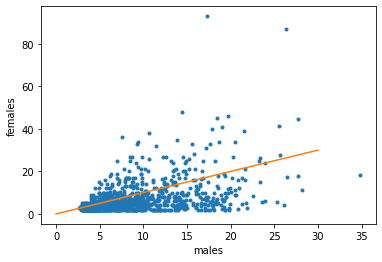

In [272]:
plt.plot(males_mean, females_mean, '.')
plt.xlabel('males')
plt.ylabel('females')
plt.plot([0,30], [0,30])
plt.show()

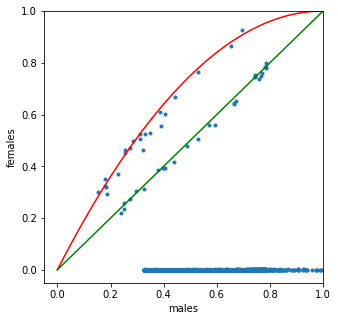

In [274]:
plt.figure(figsize=(5,5))
plt.plot(males_prev, females_prev, '.')
plt.xlabel('males')
plt.ylabel('females')
plt.xlim(-.05,1)
plt.ylim(-.05,1)
mp = np.linspace(0,1, 100)
fp_predicted = (1-(1-mp)*(1-mp))
plt.plot(mp, fp_predicted, 'r-')
plt.plot([0,1], [0,1], 'g-')


In [71]:
for s in unmapped_seqs[:100]:
    complement = s.replace('A', 't').replace('T', 'a').replace('G', 'c').replace('C', 'g').replace(
        'a', 'A').replace('t', 'T').replace('c', 'C').replace('g', 'G')
    print(human_genome.count(s), human_genome.count(complement), 
          human_genome.count(s[::-1]), human_genome.count(complement[::-1]))

0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


KeyboardInterrupt: 

In [ ]:
c = pd.read_table('/home/groups/dpwall/briannac/alt_haplotypes/results/approximate_regions/localized_unmapped.tsv', nrows=10000)
Counter([tuple(a[1]) for a in df[['chrom_pred']].iterrows()]).most_common()

In [ ]:
s = unmapped_seqs[6]
complement = s.replace('A', 't').replace('T', 'a').replace('G', 'c').replace('C', 'g').replace(
        'a', 'A').replace('t', 'T').replace('c', 'C').replace('g', 'G')
#human_genome.count(complement[::-1])
[(r.id, str(r.seq).find(complement[::-1])) for r in records]# for r in records]

In [62]:
np.cumsum([len(r) for r in records])

array([ 248387328,  491084080,  692190028,  885764973, 1067810412,
       1239937040, 1400504468, 1546763799, 1697381046, 1832139180,
       1967266949, 2100591497, 2214158183, 2315319675, 2415072870,
       2511403244, 2595680141, 2676222679, 2737930043, 2804140298,
       2849230980, 2900555906, 3054815472, 3054832041])

In [257]:
np.mean(df.chrom_pred==23.0)

0.1584

NameError: name 'kmers' is not defined